In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt

def gaussian_distance(x, sigma):
    return np.exp(-(x ** 2) / (2 * sigma ** 2))

def apply_gaussian_distance(original_map, resolution, sigma):
    # Calculate the distance transform of the binary map
    distance_map = distance_transform_edt(np.logical_not(original_map))

    # Normalize the distance values
    distance_map /= resolution

    # Apply Gaussian function to the normalized distance values
    gaussian_map = gaussian_distance(distance_map, sigma)

    return gaussian_map

# Example usage:
W = 10  # Width of the map
H = 10  # Height of the map
R = 5  # Resolution of each cell (20x20 cm)
sigma = 1  # Variance of the Gaussian function

# Create a binary map with 0s and 1s
original_map = np.random.choice([0, 1], size=(H, W))
original_map = np.zeros((H, W))
original_map[5,5] = 1.
distance_map = distance_transform_edt(np.logical_not(original_map))
distance_map /= R

# Apply the Gaussian distance function
output_map = apply_gaussian_distance(original_map, R, sigma)

# Print the original and output maps
print("Original Map:")
print(original_map)
print("\nDistance Map:")
print(distance_map)
print("\nOutput Map:")
print(output_map)

In [ ]:
%load_ext autoreload
%autoreload 2
from map_utils import build_probability_map

output_map = build_probability_map(original_map, sigma=5.)

print("Original Map:")
print(original_map)
print("\nOutput Map:")
print(output_map)

In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [26]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatchingNDT import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation
import time

class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        method = kwargs.pop('method', '_improved')
        self.map_matching = MapMatching(N=200, method=method)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, - imu_relative_ref + video_data["pos"][0:2])# I changes it for debug purposes only! original - self.estimated_relative_pos). we are trying here to convert to IMU global coordinates
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        #print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, prior, nusc_map, exp_params):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            dynamic_tracks = self.dynamic_tracker.getTracks()
            lanes = self.getLanes(prior, first_world_ref[0:2], exp_params)
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, dynamic_tracks, lanes, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, dynamic_tracks, first_world_ref[0:2], gt_relative_pos, imu_relative_ref_3d, lanes)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getLanes(self, prior, translate, exp_params):
        sx = exp_params["sx"]
        sy = exp_params["sy"]
        prior_elements = []
        #lane_width = 5.
        #w = lane_width / 2.
        for pr in prior:
            prior_len = pr["x"].shape[0]
            elem = np.zeros([prior_len, 4])
            elem[:-1,2] = pr["dx"]
            elem[-1,2] = elem[-2,2]
            elem[:-1,3] = pr["dy"]
            elem[-1,3] = elem[-2,3]
            
            elem[:, 0] = pr["x"] - translate[0] + sx
            elem[:, 1] = pr["y"] - translate[1] + sy
            
            prior_elements.append(elem)
            
        return prior_elements
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            xmin = np.min(lane["x"]) if lane["fx"] else np.min(lane["y"])
            xmax = np.max(lane["x"]) if lane["fx"] else np.max(lane["y"])
            prior_list.append({"c": (a0,a1,a2), "xmin": xmin, "xmax": xmax, "fx": lane["fx"],
                              "f": np.poly1d(lane["poly"].c), "x_start": xmin, "x_end": xmax, "fxFlag": lane["fx"]})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map, exp_params):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, prior, nusc_map, exp_params)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import json

# Specify the path to your JSON file
json_file_path = '/home/kfir/workspace/RadarLocalization/exp_config.json'

def getExperimentParams(scene):
    # Open and read the JSON file
    with open(json_file_path, 'r') as file:
        # Load the JSON data into a Python dictionary
        exp = json.load(file)

    # Now 'data' is a dictionary containing the JSON data
    return exp[f"{scene}"]

In [ ]:
#scenes = [325, 365, 426, 494, 690, 814]
scenes = [325, 365, 426]
methods = ["_basic", "_improved"]
#methods = [""]

for scene in scenes:
    for method in methods:
        print(f"scene={scene} method={method}")
        exp_params = getExperimentParams(scene)
        model = RadarLocalizer(scene_id=scene, mm=True, method=method)
        video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
        sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=2000, video_list=video_list, save_processed=True, dname=f"database{method}", exp_params=exp_params, method=method)
        sim.run(start=0, N=exp_params["N"], generate_video=False, video_with_priors=False, debug=False, exp_params=exp_params)

scene=325 method=_basic
scene_id=325 scene_name=scene-0411 map_name=singapore-hollandvillage


/home/kfir/workspace/RadarLocalization/dataset.py:390: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53803387e+15 2.30000000e+01]
 [1.53803387e+15 2.30000000e+01]
 [1.53803387e+15 2.30000000e+01]
 ...
 [1.53898521e+15 1.70000000e+01]
 [1.53898521e+15 1.70000000e+01]
 [1.53898521e+15 1.70000000e+01]]


WARNING - 2024-01-08 21:33:13,329 - legend - No handles with labels found to put in legend.
WARNING - 2024-01-08 21:33:13,335 - legend - No handles with labels found to put in legend.
WARNING - 2024-01-08 21:33:13,723 - legend - No handles with labels found to put in legend.
WARNING - 2024-01-08 21:33:13,730 - legend - No handles with labels found to put in legend.


self.dir_name /home/kfir/workspace/RadarLocalization/images/325/database_basic


  0%|          | 0/1650 [00:00<?, ?it/s]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


frame 0
frame_idx = 1
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 1/1650 [00:00<23:44,  1.16it/s]

frame 1


/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 2
Number of new plots 0
Number of dynamic tracks before run() 0


  0%|          | 2/1650 [00:01<24:21,  1.13it/s]

frame 2
frame_idx = 3
Number of new plots 0
Number of dynamic tracks before run() 0


  0%|          | 3/1650 [00:02<24:50,  1.11it/s]

frame 3
frame_idx = 4
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 4/1650 [00:05<41:34,  1.52s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

frame 4


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 5
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 5/1650 [00:08<53:28,  1.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

frame 5


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 6
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 6/1650 [00:11<1:02:25,  2.28s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 6


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 7
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 7/1650 [00:14<1:09:31,  2.54s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 7


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 8
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 8/1650 [00:18<1:15:59,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 8


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 9
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 9/1650 [00:21<1:20:17,  2.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 9


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 10
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 10/1650 [00:24<1:23:47,  3.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 10


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 11
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 11/1650 [00:28<1:25:50,  3.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 11


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 12
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 12/1650 [00:31<1:27:15,  3.20s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 12


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 13
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 13/1650 [00:34<1:28:03,  3.23s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 13


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 14
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 14/1650 [00:38<1:28:57,  3.26s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 14


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 15
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 15/1650 [00:41<1:28:40,  3.25s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 15


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 16
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 16/1650 [00:44<1:28:23,  3.25s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 16


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 17
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 17/1650 [00:47<1:27:56,  3.23s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 17


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 18
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 18/1650 [00:51<1:27:58,  3.23s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 18


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 19
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 19/1650 [00:54<1:28:55,  3.27s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 19


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 20
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 20/1650 [00:57<1:29:56,  3.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 20


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 21
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|▏         | 21/1650 [01:01<1:31:16,  3.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 21


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 22
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|▏         | 22/1650 [01:04<1:31:12,  3.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 22


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 23
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|▏         | 23/1650 [01:08<1:31:24,  3.37s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 23


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 24
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|▏         | 24/1650 [01:11<1:31:16,  3.37s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 24


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 25
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 25/1650 [01:14<1:31:47,  3.39s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 25


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 26
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 26/1650 [01:18<1:32:21,  3.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 26


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 27
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 27/1650 [01:21<1:33:36,  3.46s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 27


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 28
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 28/1650 [01:25<1:33:50,  3.47s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 28


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 29
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 29/1650 [01:28<1:34:45,  3.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 29


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 30
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 30/1650 [01:32<1:35:09,  3.52s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 30


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 31
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 31/1650 [01:36<1:35:37,  3.54s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 31


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 32
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 32/1650 [01:39<1:35:04,  3.53s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 32


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 33
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 33/1650 [01:43<1:34:39,  3.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 33


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 34
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 34/1650 [01:46<1:35:45,  3.56s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 34


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 35
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 35/1650 [01:50<1:36:27,  3.58s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 35


/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])
/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 36
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 36/1650 [01:57<2:04:38,  4.63s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 36


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 37
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 37/1650 [02:01<1:56:27,  4.33s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 37


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 38
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 38/1650 [02:04<1:50:46,  4.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 38


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 39
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 39/1650 [02:08<1:47:27,  4.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 39


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 40
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 40/1650 [02:12<1:45:13,  3.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 40


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 41
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 41/1650 [02:15<1:43:26,  3.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 41


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 42
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 42/1650 [02:19<1:42:02,  3.81s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 42


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 43
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 43/1650 [02:23<1:41:38,  3.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 43


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 44
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 44/1650 [02:27<1:42:22,  3.82s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 44


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 45
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 45/1650 [02:31<1:42:45,  3.84s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 45


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 46
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 46/1650 [02:35<1:43:13,  3.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 46


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 47
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 47/1650 [02:38<1:43:57,  3.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 47


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 48
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 48/1650 [02:42<1:43:45,  3.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 48


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 49
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 49/1650 [02:46<1:44:36,  3.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 49


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 50
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 50/1650 [02:50<1:44:42,  3.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 50


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 51
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 51/1650 [02:54<1:45:15,  3.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 51


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 52
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 52/1650 [02:58<1:44:38,  3.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 52


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 53
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 53/1650 [03:02<1:46:41,  4.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 53


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 54
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 54/1650 [03:07<1:48:07,  4.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 54


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 55
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 55/1650 [03:11<1:49:32,  4.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 55


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 56
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 56/1650 [03:15<1:49:37,  4.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 56


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 57
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 57/1650 [03:19<1:50:26,  4.16s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 57


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 58
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▎         | 58/1650 [03:23<1:49:55,  4.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 58


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 59
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▎         | 59/1650 [03:27<1:49:10,  4.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 59


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 60
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▎         | 60/1650 [03:31<1:49:08,  4.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 60


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 61
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▎         | 61/1650 [03:36<1:48:40,  4.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 61


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 62
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 62/1650 [03:40<1:48:11,  4.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 62


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 63
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 63/1650 [03:44<1:47:06,  4.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 63


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 64
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 64/1650 [03:48<1:46:07,  4.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 64


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 65
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 65/1650 [03:51<1:45:20,  3.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 65


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 66
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 66/1650 [03:55<1:45:34,  4.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 66


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 67
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 67/1650 [03:59<1:45:42,  4.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 67


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 68
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 68/1650 [04:04<1:46:01,  4.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 68


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 69
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 69/1650 [04:08<1:46:10,  4.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 69


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 70
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 70/1650 [04:12<1:46:20,  4.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 70


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 71
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 71/1650 [04:16<1:46:50,  4.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 71


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 72
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 72/1650 [04:20<1:47:35,  4.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 72


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 73
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 73/1650 [04:24<1:48:10,  4.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 73


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 74
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 74/1650 [04:28<1:48:37,  4.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 74


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 75
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 75/1650 [04:33<1:49:18,  4.16s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 75


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 76
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 76/1650 [04:37<1:49:08,  4.16s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 76


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 77
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 77/1650 [04:41<1:48:51,  4.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 77


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 78
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 78/1650 [04:45<1:48:41,  4.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 78


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 79
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 79/1650 [04:49<1:45:23,  4.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 79


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 80
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 80/1650 [04:52<1:42:41,  3.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 80


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 81
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 81/1650 [04:56<1:40:38,  3.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 81


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 82
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 82/1650 [05:00<1:39:05,  3.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 82


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 83
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 83/1650 [05:03<1:38:18,  3.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 83


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 84
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 84/1650 [05:07<1:37:40,  3.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 84


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 85
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 85/1650 [05:11<1:36:44,  3.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 85


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 86
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 86/1650 [05:14<1:35:58,  3.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 86


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 87
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 87/1650 [05:18<1:34:56,  3.64s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 87


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 88
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 88/1650 [05:21<1:34:18,  3.62s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 88


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 89
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 89/1650 [05:25<1:33:29,  3.59s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 89


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 90
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▌         | 90/1650 [05:29<1:33:02,  3.58s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 90


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 91
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 91/1650 [05:32<1:32:41,  3.57s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 91


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 92
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 92/1650 [05:36<1:32:08,  3.55s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 92


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 93
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 93/1650 [05:39<1:28:49,  3.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 93


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 94
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 94/1650 [05:42<1:25:48,  3.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 94


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 95
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 95/1650 [05:45<1:23:25,  3.22s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 95


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 96
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 96/1650 [05:48<1:23:01,  3.21s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 96


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 97
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 97/1650 [05:51<1:22:15,  3.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 97


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 98
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 98/1650 [05:54<1:22:16,  3.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 98


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 99
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 99/1650 [05:57<1:21:54,  3.17s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

frame 99


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 100
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 100/1650 [06:00<1:20:38,  3.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 100


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 101
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 101/1650 [06:03<1:20:11,  3.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 101


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 102
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 102/1650 [06:06<1:18:44,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 102


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 103
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▌         | 103/1650 [06:09<1:16:56,  2.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 103


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 104
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▋         | 104/1650 [06:12<1:15:46,  2.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 104


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 105
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▋         | 105/1650 [06:15<1:14:37,  2.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 105


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 106
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▋         | 106/1650 [06:18<1:13:33,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 106


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 107
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  6%|▋         | 107/1650 [06:20<1:12:46,  2.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 107


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 108
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 108/1650 [06:23<1:12:25,  2.82s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 108


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 109
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 109/1650 [06:26<1:12:54,  2.84s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 109


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 110
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 110/1650 [06:29<1:12:43,  2.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 110


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 111
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 111/1650 [06:32<1:12:20,  2.82s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 111


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 112
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 112/1650 [06:34<1:11:59,  2.81s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 112


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 113
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 113/1650 [06:37<1:11:33,  2.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 113


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 114
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 114/1650 [06:40<1:11:11,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 114


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 115
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 115/1650 [06:43<1:11:17,  2.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 115


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 116
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 116/1650 [06:46<1:11:01,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 116


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 117
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 117/1650 [06:48<1:10:34,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 117


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 118
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 118/1650 [06:51<1:10:40,  2.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 118


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 119
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 119/1650 [06:54<1:10:29,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 119


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 120
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 120/1650 [06:56<1:10:13,  2.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 120


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 121
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 121/1650 [06:59<1:09:50,  2.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 121


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 122
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 122/1650 [07:02<1:09:46,  2.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 122


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 123
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 123/1650 [07:05<1:09:27,  2.73s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 123


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 124
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 124/1650 [07:07<1:09:25,  2.73s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 124


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 125
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 125/1650 [07:10<1:08:52,  2.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 125


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 126
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 126/1650 [07:13<1:08:36,  2.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 126


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 127
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 127/1650 [07:15<1:08:08,  2.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 127


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 128
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 128/1650 [07:18<1:08:05,  2.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 128


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 129
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 129/1650 [07:21<1:07:52,  2.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 129


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 130
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 130/1650 [07:23<1:07:45,  2.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 130


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 131
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 131/1650 [07:26<1:08:02,  2.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 131


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 132
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 132/1650 [07:29<1:08:30,  2.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 132


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 133
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 133/1650 [07:32<1:08:48,  2.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 133


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 134
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 134/1650 [07:34<1:08:42,  2.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 134


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 135
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 135/1650 [07:37<1:09:00,  2.73s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 135


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 136
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 136/1650 [07:40<1:09:29,  2.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 136


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 137
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 137/1650 [07:43<1:09:09,  2.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 137


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 138
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 138/1650 [07:45<1:09:28,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 138


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 139
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 139/1650 [07:48<1:09:25,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 139


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 140
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 140/1650 [07:51<1:09:21,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 140


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 141
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▊         | 141/1650 [07:54<1:09:11,  2.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 141


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 142
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▊         | 142/1650 [07:56<1:08:24,  2.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 142


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 143
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▊         | 143/1650 [07:59<1:08:01,  2.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 143


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 144
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▊         | 144/1650 [08:02<1:07:29,  2.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 144


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 145
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 145/1650 [08:04<1:07:40,  2.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 145


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 146
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 146/1650 [08:07<1:07:36,  2.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 146


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 147
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 147/1650 [08:10<1:07:30,  2.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 147


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 148
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 148/1650 [08:12<1:07:27,  2.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 148


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 149
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 149/1650 [08:15<1:08:41,  2.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 149


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 150
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 150/1650 [08:18<1:09:16,  2.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 150


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 151
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 151/1650 [08:21<1:09:28,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 151


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 152
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 152/1650 [08:24<1:09:03,  2.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 152


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 153
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 153/1650 [08:27<1:09:45,  2.80s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 153


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 154
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 154/1650 [08:29<1:10:42,  2.84s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 154


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 155
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 155/1650 [08:32<1:11:06,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 155


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 156
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  9%|▉         | 156/1650 [08:35<1:11:13,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 156


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 157
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 157/1650 [08:38<1:11:02,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 157


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 158
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 158/1650 [08:41<1:10:55,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 158


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 159
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 159/1650 [08:44<1:11:26,  2.88s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 159


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 160
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 160/1650 [08:47<1:10:59,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 160


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 161
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 161/1650 [08:49<1:10:46,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 161


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 162
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 162/1650 [08:52<1:09:48,  2.81s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 162


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 163
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 163/1650 [08:55<1:09:04,  2.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 163


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 164
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|▉         | 164/1650 [08:58<1:07:54,  2.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 164


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 165
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 165/1650 [09:00<1:06:39,  2.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 165


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 166
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 166/1650 [09:03<1:06:08,  2.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 166


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 167
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 167/1650 [09:05<1:05:51,  2.66s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 167


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 168
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 168/1650 [09:08<1:05:28,  2.65s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 168


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 169
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 169/1650 [09:11<1:04:22,  2.61s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 169


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 170
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 170/1650 [09:13<1:03:50,  2.59s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 170


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 171
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 171/1650 [09:16<1:03:24,  2.57s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 171


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 172
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 172/1650 [09:18<1:02:46,  2.55s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 172


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 173
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 10%|█         | 173/1650 [09:21<1:02:38,  2.54s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 173


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 174
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 174/1650 [09:23<1:02:30,  2.54s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 174


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 175
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 175/1650 [09:26<1:02:51,  2.56s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 175


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 176
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 176/1650 [09:29<1:04:27,  2.62s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 176


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 177
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 177/1650 [09:31<1:05:20,  2.66s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 177


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 178
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 178/1650 [09:34<1:05:19,  2.66s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 178


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 179
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 179/1650 [09:37<1:05:23,  2.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 179


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 180
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 180/1650 [09:39<1:05:31,  2.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 180


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 181
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 181/1650 [09:42<1:05:46,  2.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 181


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 182
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 182/1650 [09:45<1:06:05,  2.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 182


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 183
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 183/1650 [09:48<1:06:26,  2.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 183


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 184
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 184/1650 [09:50<1:06:46,  2.73s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 184


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 185
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█         | 185/1650 [09:53<1:06:58,  2.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 185


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 186
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█▏        | 186/1650 [09:56<1:06:55,  2.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 186


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 187
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█▏        | 187/1650 [09:59<1:06:58,  2.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 187


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 188
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█▏        | 188/1650 [10:01<1:07:09,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 188


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 189
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 11%|█▏        | 189/1650 [10:04<1:07:12,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 189


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 190
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 190/1650 [10:07<1:07:11,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 190


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 191
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 191/1650 [10:10<1:07:04,  2.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 191


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 192
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 192/1650 [10:12<1:07:16,  2.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 192


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 193
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 193/1650 [10:15<1:07:24,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 193


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 194
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 194/1650 [10:18<1:07:20,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 194


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 195
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 195/1650 [10:21<1:07:07,  2.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 195


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 196
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 196/1650 [10:24<1:07:08,  2.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 196


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 197
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 197/1650 [10:26<1:07:38,  2.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 197


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 198
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 198/1650 [10:29<1:08:16,  2.82s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 198


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 199
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 199/1650 [10:32<1:08:19,  2.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 199


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 200
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 200/1650 [10:35<1:08:52,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 200


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 201
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 201/1650 [10:38<1:08:52,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 201


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 202
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 202/1650 [10:41<1:09:08,  2.87s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 202


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 203
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 203/1650 [10:44<1:08:51,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 203


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 204
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 204/1650 [10:46<1:08:38,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 204


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 205
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 205/1650 [10:49<1:08:37,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 205


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 206
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 12%|█▏        | 206/1650 [10:52<1:08:48,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 206


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 207
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 207/1650 [10:55<1:09:21,  2.88s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 207


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 208
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 208/1650 [10:58<1:09:28,  2.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 208


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 209
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 209/1650 [11:01<1:09:50,  2.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 209


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 210
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 210/1650 [11:04<1:09:48,  2.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 210


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 211
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 211/1650 [11:07<1:09:40,  2.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 211


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 212
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 212/1650 [11:10<1:10:10,  2.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 212


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 213
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 213/1650 [11:13<1:09:32,  2.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 213


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 214
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 214/1650 [11:15<1:08:59,  2.88s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 214


/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])
/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 215
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 215/1650 [11:21<1:31:23,  3.82s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 215


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 216
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 216/1650 [11:24<1:24:18,  3.53s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 216


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 217
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 217/1650 [11:27<1:19:10,  3.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 217


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 218
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 218/1650 [11:30<1:17:12,  3.23s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 218


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 219
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 219/1650 [11:33<1:15:40,  3.17s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 219


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 220
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 220/1650 [11:36<1:14:41,  3.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 220


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 221
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 221/1650 [11:39<1:14:18,  3.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 221


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 222
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 13%|█▎        | 222/1650 [11:42<1:14:00,  3.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 222


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 223
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▎        | 223/1650 [11:45<1:13:46,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 223


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 224
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▎        | 224/1650 [11:49<1:13:24,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 224


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 225
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▎        | 225/1650 [11:52<1:13:25,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 225


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 226
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▎        | 226/1650 [11:55<1:13:22,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 226


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 227
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 227/1650 [11:58<1:13:12,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 227


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 228
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 228/1650 [12:01<1:13:13,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 228


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 229
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 229/1650 [12:04<1:13:07,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 229


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 230
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 230/1650 [12:07<1:13:44,  3.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 230


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 231
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 231/1650 [12:10<1:14:23,  3.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 231


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 232
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 232/1650 [12:14<1:14:08,  3.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 232


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 233
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 233/1650 [12:17<1:13:50,  3.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 233


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 234
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 234/1650 [12:20<1:13:19,  3.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 234


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 235
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 235/1650 [12:23<1:12:34,  3.08s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 235


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 236
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 236/1650 [12:26<1:12:58,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 236


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 237
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 237/1650 [12:29<1:12:54,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 237


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 238
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 238/1650 [12:32<1:12:00,  3.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 238


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 239
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 14%|█▍        | 239/1650 [12:35<1:11:00,  3.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 239


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 240
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 240/1650 [12:38<1:10:04,  2.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 240


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 241
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 241/1650 [12:41<1:09:25,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 241


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 242
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 242/1650 [12:44<1:09:30,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 242


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 243
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 243/1650 [12:47<1:10:07,  2.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 243


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 244
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 244/1650 [12:50<1:09:45,  2.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 244


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 245
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 245/1650 [12:53<1:09:33,  2.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 245


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 246
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 246/1650 [12:56<1:10:00,  2.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 246


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 247
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▍        | 247/1650 [12:59<1:11:08,  3.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 247


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 248
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 248/1650 [13:02<1:11:17,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 248


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 249
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 249/1650 [13:05<1:11:15,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 249


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 250
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 250/1650 [13:08<1:11:44,  3.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 250


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 251
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 251/1650 [13:11<1:11:55,  3.08s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 251


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 252
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 252/1650 [13:14<1:11:46,  3.08s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 252


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 253
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 253/1650 [13:17<1:12:08,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 253


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 254
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 254/1650 [13:20<1:11:16,  3.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 254


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 255
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 15%|█▌        | 255/1650 [13:23<1:10:59,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 255


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 256
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 256/1650 [13:26<1:10:59,  3.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 256


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 257
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 257/1650 [13:29<1:10:33,  3.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 257


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 258
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 258/1650 [13:32<1:10:00,  3.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 258


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 259
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 259/1650 [13:35<1:07:36,  2.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 259


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 260
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 260/1650 [13:38<1:06:21,  2.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 260


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 261
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 261/1650 [13:41<1:05:25,  2.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 261


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 262
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 262/1650 [13:43<1:04:29,  2.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 262


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 263
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 263/1650 [13:46<1:04:11,  2.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 263


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 264
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 264/1650 [13:49<1:03:04,  2.73s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 264


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 265
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 265/1650 [13:51<1:01:42,  2.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 265


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 266
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 266/1650 [13:54<1:00:43,  2.63s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 266


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 267
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 267/1650 [13:56<59:36,  2.59s/it]  /home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 267


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 268
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▌        | 268/1650 [13:59<58:34,  2.54s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 268


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 269
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▋        | 269/1650 [14:01<57:08,  2.48s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 269


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 270
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▋        | 270/1650 [14:03<56:42,  2.47s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 270


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 271
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▋        | 271/1650 [14:06<56:28,  2.46s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 271


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 272
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 16%|█▋        | 272/1650 [14:08<56:50,  2.48s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 272


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 273
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 273/1650 [14:11<57:08,  2.49s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 273


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 274
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 274/1650 [14:13<57:23,  2.50s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 274


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 275
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 275/1650 [14:16<57:28,  2.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 275


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 276
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 276/1650 [14:19<58:57,  2.57s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 276


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 277
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 277/1650 [14:21<59:57,  2.62s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depre

frame 277


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 278
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 278/1650 [14:24<1:01:53,  2.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 278


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 279
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 279/1650 [14:27<1:03:44,  2.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 279


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 280
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 280/1650 [14:30<1:05:02,  2.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 280


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 281
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 281/1650 [14:33<1:06:20,  2.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 281


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 282
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 282/1650 [14:36<1:07:31,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 282


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 283
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 283/1650 [14:39<1:08:16,  3.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 283


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 284
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 284/1650 [14:43<1:09:10,  3.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 284


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 285
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 285/1650 [14:46<1:09:48,  3.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 285


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 286
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 286/1650 [14:49<1:10:26,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 286


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 287
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 287/1650 [14:52<1:11:30,  3.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 287


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 288
Number of new plots 0
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 288/1650 [14:55<1:12:46,  3.21s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 288


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 289
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 289/1650 [14:59<1:13:23,  3.24s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 289


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 290
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 290/1650 [15:02<1:14:45,  3.30s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 290


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 291
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 291/1650 [15:06<1:15:21,  3.33s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 291


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 292
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 292/1650 [15:09<1:15:32,  3.34s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 292


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 293
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 293/1650 [15:12<1:16:04,  3.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 293


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 294
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 294/1650 [15:16<1:16:13,  3.37s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 294


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 295
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 295/1650 [15:19<1:15:49,  3.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 295


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 296
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 296/1650 [15:22<1:15:15,  3.33s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 296


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 297
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 297/1650 [15:26<1:16:17,  3.38s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 297


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 298
Number of new plots 0
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 298/1650 [15:29<1:16:17,  3.39s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 298


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 299
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 299/1650 [15:33<1:15:55,  3.37s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 299


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 300
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 300/1650 [15:36<1:15:45,  3.37s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 300


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 301
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 301/1650 [15:39<1:15:56,  3.38s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 301


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 302
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 302/1650 [15:43<1:15:59,  3.38s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 302


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 303
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 303/1650 [15:46<1:16:23,  3.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 303


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 304
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 304/1650 [15:50<1:16:29,  3.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 304


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 305
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 305/1650 [15:53<1:16:43,  3.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 305


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 306
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▊        | 306/1650 [15:57<1:16:28,  3.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 306


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 307
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▊        | 307/1650 [16:00<1:16:17,  3.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 307


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 308
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▊        | 308/1650 [16:03<1:15:38,  3.38s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 308


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 309
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▊        | 309/1650 [16:07<1:15:22,  3.37s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 309


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 310
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 310/1650 [16:10<1:16:12,  3.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 310


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 311
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 311/1650 [16:14<1:16:22,  3.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 311


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 312
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 312/1650 [16:17<1:15:16,  3.38s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 312


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 313
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 313/1650 [16:20<1:15:30,  3.39s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 313


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 314
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 314/1650 [16:24<1:15:17,  3.38s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 314


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 315
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 315/1650 [16:27<1:15:43,  3.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 315


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 316
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 316/1650 [16:30<1:15:45,  3.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 316


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 317
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 317/1650 [16:34<1:15:53,  3.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 317


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 318
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 318/1650 [16:37<1:15:31,  3.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 318


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 319
Number of new plots 0
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 319/1650 [16:41<1:15:27,  3.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 319


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 320
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 320/1650 [16:44<1:14:07,  3.34s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 320


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 321
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 19%|█▉        | 321/1650 [16:47<1:13:15,  3.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 321


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 322
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 322/1650 [16:50<1:12:06,  3.26s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 322


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 323
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 323/1650 [16:53<1:11:12,  3.22s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 323


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 324
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 324/1650 [16:57<1:10:50,  3.21s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 324


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 325
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 325/1650 [17:00<1:09:52,  3.16s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 325


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 326
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 326/1650 [17:03<1:09:30,  3.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 326


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 327
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 327/1650 [17:06<1:09:54,  3.17s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 327


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 328
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 328/1650 [17:09<1:10:41,  3.21s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 328


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 329
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|█▉        | 329/1650 [17:12<1:09:33,  3.16s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 329


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 330
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 330/1650 [17:15<1:08:53,  3.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 330


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 331
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 331/1650 [17:18<1:08:27,  3.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 331


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 332
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 332/1650 [17:22<1:08:27,  3.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 332


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 333
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 333/1650 [17:25<1:07:51,  3.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 333


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 334
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 334/1650 [17:28<1:07:31,  3.08s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 334


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 335
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 335/1650 [17:31<1:06:44,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 335


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 336
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 336/1650 [17:34<1:06:38,  3.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 336


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 337
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 337/1650 [17:36<1:05:24,  2.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 337


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 338
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 20%|██        | 338/1650 [17:39<1:04:49,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 338


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 339
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 339/1650 [17:42<1:04:19,  2.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 339


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 340
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 340/1650 [17:45<1:04:42,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 340


/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])
/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 341
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 341/1650 [17:48<1:04:28,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 341


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 342
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 342/1650 [17:51<1:03:57,  2.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 342


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 343
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 343/1650 [17:54<1:04:05,  2.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 343


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 344
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 344/1650 [17:57<1:04:33,  2.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 344


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 345
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 345/1650 [18:00<1:05:26,  3.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 345


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 346
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 346/1650 [18:03<1:06:12,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 346


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 347
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 347/1650 [18:06<1:06:18,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 347


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 348
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 348/1650 [18:09<1:06:09,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 348


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 349
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 349/1650 [18:13<1:06:08,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 349


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 350
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██        | 350/1650 [18:16<1:06:19,  3.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 350


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 351
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██▏       | 351/1650 [18:19<1:05:53,  3.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 351


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 352
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██▏       | 352/1650 [18:22<1:06:39,  3.08s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 352


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 353
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██▏       | 353/1650 [18:25<1:06:57,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 353


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 354
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 21%|██▏       | 354/1650 [18:28<1:06:23,  3.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 354


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 355
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 355/1650 [18:31<1:06:07,  3.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 355


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 356
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 356/1650 [18:34<1:06:52,  3.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 356


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 357
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 357/1650 [18:37<1:07:36,  3.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 357


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 358
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 358/1650 [18:40<1:07:22,  3.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 358


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 359
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 359/1650 [18:44<1:07:11,  3.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 359


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 360
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 360/1650 [18:47<1:06:45,  3.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 360


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 361
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 361/1650 [18:50<1:05:53,  3.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 361


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 362
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 362/1650 [18:53<1:05:27,  3.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 362


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 363
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 363/1650 [18:56<1:04:47,  3.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 363


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 364
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 364/1650 [18:59<1:04:20,  3.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 364


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 365
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 365/1650 [19:01<1:03:41,  2.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 365


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 366
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 366/1650 [19:04<1:03:36,  2.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 366


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 367
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 367/1650 [19:07<1:03:09,  2.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 367


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 368
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 368/1650 [19:10<1:03:46,  2.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 368


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 369
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 369/1650 [19:13<1:03:15,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 369


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 370
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 370/1650 [19:16<1:03:03,  2.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 370


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 371
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 22%|██▏       | 371/1650 [19:19<1:03:55,  3.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 371


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 372
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 372/1650 [19:22<1:04:27,  3.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 372


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 373
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 373/1650 [19:27<1:11:36,  3.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 373


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 374
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 374/1650 [19:31<1:16:35,  3.60s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 374


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 375
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 375/1650 [19:35<1:20:23,  3.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 375


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 376
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 376/1650 [19:39<1:22:59,  3.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 376


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 377
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 377/1650 [19:43<1:24:18,  3.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 377


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 378
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 378/1650 [19:47<1:25:36,  4.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 378


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 379
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 379/1650 [19:52<1:26:48,  4.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 379


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 380
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 380/1650 [19:56<1:27:11,  4.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 380


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 381
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 381/1650 [20:00<1:27:49,  4.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 381


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 382
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 382/1650 [20:06<1:36:51,  4.58s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 382


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 383
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 383/1650 [20:11<1:42:38,  4.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 383


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 384
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 384/1650 [20:16<1:39:14,  4.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 384


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 385
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 385/1650 [20:20<1:38:27,  4.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 385


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 386
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 386/1650 [20:25<1:37:39,  4.64s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 386


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 387
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 387/1650 [20:29<1:37:50,  4.65s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 387


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 388
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▎       | 388/1650 [20:34<1:38:29,  4.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 388


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 389
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▎       | 389/1650 [20:39<1:38:17,  4.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 389


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 390
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▎       | 390/1650 [20:43<1:37:57,  4.66s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 390


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 391
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▎       | 391/1650 [20:48<1:35:46,  4.56s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 391


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 392
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 392/1650 [20:52<1:34:05,  4.49s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 392


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 393
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 393/1650 [20:56<1:32:54,  4.43s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 393


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 394
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 394/1650 [21:01<1:31:19,  4.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 394


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 395
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 395/1650 [21:05<1:30:52,  4.34s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 395


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 396
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 396/1650 [21:09<1:30:28,  4.33s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 396


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 397
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 397/1650 [21:14<1:30:50,  4.35s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 397


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 398
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 398/1650 [21:18<1:31:52,  4.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 398


/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])
/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 399
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 399/1650 [21:26<1:53:31,  5.44s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 399


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 400
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 400/1650 [21:30<1:47:00,  5.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 400


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 401
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 401/1650 [21:35<1:42:34,  4.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 401


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 402
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 402/1650 [21:39<1:40:08,  4.81s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 402


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 403
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 403/1650 [21:45<1:44:05,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 403


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 404
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 24%|██▍       | 404/1650 [21:51<1:48:36,  5.23s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 404


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 405
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 405/1650 [21:56<1:50:40,  5.33s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 405


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 406
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 406/1650 [22:02<1:52:46,  5.44s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 406


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 407
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 407/1650 [22:08<1:59:18,  5.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 407


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 408
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 408/1650 [22:15<2:03:03,  5.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 408


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 409
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 409/1650 [22:21<2:04:40,  6.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 409


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 410
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 410/1650 [22:27<2:01:47,  5.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 410


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 411
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 411/1650 [22:33<2:02:37,  5.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 411


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 412
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▍       | 412/1650 [22:39<2:02:35,  5.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 412


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 413
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 413/1650 [22:45<2:03:09,  5.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 413


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 414
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 414/1650 [22:51<2:04:50,  6.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 414


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 415
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 415/1650 [22:57<2:06:17,  6.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 415


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 416
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 416/1650 [23:03<2:07:04,  6.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 416


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 417
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 417/1650 [23:10<2:08:05,  6.23s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 417


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 418
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 418/1650 [23:16<2:09:51,  6.32s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 418


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 419
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 419/1650 [23:23<2:09:22,  6.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 419


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 420
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 25%|██▌       | 420/1650 [23:28<2:04:30,  6.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 420


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 421
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 421/1650 [23:34<2:03:14,  6.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 421


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 422
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 422/1650 [23:40<2:02:33,  5.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 422


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 423
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 423/1650 [23:45<1:54:30,  5.60s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 423


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 424
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 424/1650 [23:49<1:49:17,  5.35s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 424


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 425
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 425/1650 [23:54<1:45:41,  5.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 425


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 426
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 426/1650 [23:59<1:44:19,  5.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 426


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 427
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 427/1650 [24:04<1:43:25,  5.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 427


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 428
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 428/1650 [24:09<1:43:09,  5.06s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 428


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 429
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 429/1650 [24:14<1:42:07,  5.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 429


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 430
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 430/1650 [24:19<1:42:08,  5.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 430


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 431
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 431/1650 [24:24<1:42:21,  5.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 431


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 432
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 432/1650 [24:28<1:37:58,  4.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 432


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 433
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 433/1650 [24:33<1:38:51,  4.87s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 433


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 434
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▋       | 434/1650 [24:38<1:39:20,  4.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 434


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 435
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▋       | 435/1650 [24:44<1:40:28,  4.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 435


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 436
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▋       | 436/1650 [24:49<1:41:39,  5.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 436


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 437
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▋       | 437/1650 [24:54<1:42:40,  5.08s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 437


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 438
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 438/1650 [24:59<1:42:45,  5.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 438


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 439
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 439/1650 [25:04<1:43:20,  5.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 439


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 440
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 440/1650 [25:09<1:43:19,  5.12s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 440


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 441
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 441/1650 [25:15<1:44:10,  5.17s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 441


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 442
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 442/1650 [25:19<1:40:31,  4.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 442


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 443
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 443/1650 [25:24<1:37:17,  4.84s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 443


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 444
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 444/1650 [25:28<1:34:14,  4.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 444


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 445
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 445/1650 [25:33<1:35:58,  4.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 445


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 446
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 446/1650 [25:38<1:36:54,  4.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 446


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 447
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 447/1650 [25:43<1:37:53,  4.88s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 447


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 448
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 448/1650 [25:48<1:39:17,  4.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 448


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 449
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 449/1650 [25:53<1:38:57,  4.94s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 449


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 450
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 450/1650 [25:59<1:45:00,  5.25s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 450


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 451
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 451/1650 [26:05<1:48:58,  5.45s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 451


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 452
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 452/1650 [26:11<1:51:44,  5.60s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 452


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 453
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 453/1650 [26:17<1:54:11,  5.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 453


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 454
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 454/1650 [26:22<1:50:55,  5.57s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 454


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 455
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 455/1650 [26:27<1:48:52,  5.47s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 455


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 456
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 456/1650 [26:33<1:50:01,  5.53s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 456


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 457
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 457/1650 [26:39<1:51:28,  5.61s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 457


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 458
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 458/1650 [26:45<1:52:27,  5.66s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 458


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 459
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 459/1650 [26:50<1:53:16,  5.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 459


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 460
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 460/1650 [26:56<1:54:33,  5.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 460


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 461
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 461/1650 [27:02<1:56:58,  5.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 461


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 462
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 462/1650 [27:09<1:58:36,  5.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 462


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 463
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 463/1650 [27:15<1:59:39,  6.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 463


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 464
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 464/1650 [27:21<1:59:31,  6.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 464


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 465
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 465/1650 [27:27<1:58:58,  6.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 465


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 466
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 466/1650 [27:33<1:58:23,  6.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 466


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 467
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 467/1650 [27:39<1:56:57,  5.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 467


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 468
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 468/1650 [27:44<1:56:10,  5.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 468


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 469
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 469/1650 [27:50<1:55:16,  5.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 469


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 470
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 470/1650 [27:56<1:55:00,  5.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 470


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 471
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▊       | 471/1650 [28:02<1:55:32,  5.88s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 471


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 472
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▊       | 472/1650 [28:08<1:56:19,  5.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 472


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 473
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▊       | 473/1650 [28:14<1:55:49,  5.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 473


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 474
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▊       | 474/1650 [28:20<1:55:35,  5.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 474


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 475
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 475/1650 [28:26<1:54:54,  5.87s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 475


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 476
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 476/1650 [28:32<1:59:13,  6.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 476


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 477
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 477/1650 [28:39<2:00:58,  6.19s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 477


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 478
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 478/1650 [28:45<2:02:55,  6.29s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 478


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 479
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 479/1650 [28:52<2:03:52,  6.35s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 479


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 480
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 480/1650 [28:58<2:03:45,  6.35s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 480


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 481
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 481/1650 [29:04<2:04:36,  6.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 481


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 482
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 482/1650 [29:11<2:05:14,  6.43s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 482


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 483
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 483/1650 [29:17<2:01:34,  6.25s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 483


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 484
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 484/1650 [29:23<2:02:41,  6.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 484


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 485
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 485/1650 [29:30<2:03:32,  6.36s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 485


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 486
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 486/1650 [29:36<2:03:53,  6.39s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 486


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 487
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 487/1650 [29:43<2:04:25,  6.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 487


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 488
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 488/1650 [29:49<2:06:05,  6.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 488


/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])
/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 489
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 489/1650 [29:56<2:08:17,  6.63s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 489


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 490
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 490/1650 [30:03<2:09:37,  6.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 490


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 491
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 491/1650 [30:10<2:11:10,  6.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 491


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 492
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 492/1650 [30:17<2:11:12,  6.80s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 492


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 493
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 493/1650 [30:24<2:11:56,  6.84s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 493


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 494
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 494/1650 [30:31<2:12:52,  6.90s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 494


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 495
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 495/1650 [30:38<2:13:08,  6.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 495


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 496
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 496/1650 [30:45<2:12:20,  6.88s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 496


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 497
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 497/1650 [30:51<2:11:10,  6.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 497


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 498
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 498/1650 [30:58<2:10:19,  6.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 498


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 499
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 499/1650 [31:04<2:07:58,  6.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 499


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 500
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 500/1650 [31:11<2:05:10,  6.53s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 500


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 501
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 501/1650 [31:17<2:02:35,  6.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 501


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 502
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 502/1650 [31:23<2:00:41,  6.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 502


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 503
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 503/1650 [31:29<1:59:20,  6.24s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 503


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 504
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 504/1650 [31:35<1:59:26,  6.25s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 504


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 505
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 505/1650 [31:41<1:58:38,  6.22s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 505


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 506
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 506/1650 [31:48<1:58:08,  6.20s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 506


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 507
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 507/1650 [31:54<1:57:03,  6.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 507


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 508
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 508/1650 [32:00<1:56:06,  6.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 508


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 509
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 509/1650 [32:06<1:55:48,  6.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 509


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 510
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 510/1650 [32:12<1:55:55,  6.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 510


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 511
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 511/1650 [32:18<1:55:58,  6.11s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 511


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 512
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 512/1650 [32:24<1:56:16,  6.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 512


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 513
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 513/1650 [32:30<1:56:19,  6.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 513


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 514
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 514/1650 [32:36<1:55:59,  6.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 514


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 515
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███       | 515/1650 [32:42<1:56:00,  6.13s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 515


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 516
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███▏      | 516/1650 [32:49<1:56:50,  6.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 516


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 517
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███▏      | 517/1650 [32:55<1:56:38,  6.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 517


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 518
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███▏      | 518/1650 [33:01<1:56:54,  6.20s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 518


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 519
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 31%|███▏      | 519/1650 [33:07<1:56:03,  6.16s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 519


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 520
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 520/1650 [33:13<1:56:28,  6.18s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 520


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 521
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 521/1650 [33:19<1:53:27,  6.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 521


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 522
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 522/1650 [33:25<1:51:21,  5.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 522


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 523
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 523/1650 [33:30<1:49:58,  5.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 523


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 524
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 524/1650 [33:36<1:49:00,  5.81s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 524


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 525
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 525/1650 [33:42<1:46:45,  5.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 525


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 526
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 526/1650 [33:47<1:46:25,  5.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 526


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 527
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 527/1650 [33:53<1:46:22,  5.68s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 527


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 528
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 528/1650 [33:59<1:46:25,  5.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 528


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 529
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 529/1650 [34:04<1:46:39,  5.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 529


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 530
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 530/1650 [34:10<1:46:26,  5.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 530


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 531
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 531/1650 [34:16<1:46:57,  5.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 531


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 532
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 532/1650 [34:22<1:46:33,  5.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 532


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 533
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 533/1650 [34:27<1:46:21,  5.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 533


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 534
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 534/1650 [34:33<1:46:19,  5.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 534


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 535
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 535/1650 [34:39<1:46:44,  5.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 535


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 536
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 536/1650 [34:45<1:47:05,  5.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 536


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 537
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 537/1650 [34:50<1:44:16,  5.62s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 537


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 538
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 538/1650 [34:55<1:42:03,  5.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 538


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 539
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 539/1650 [35:00<1:39:51,  5.39s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 539


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 540
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 540/1650 [35:05<1:38:14,  5.31s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 540


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 541
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 541/1650 [35:10<1:36:04,  5.20s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 541


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 542
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 542/1650 [35:15<1:35:03,  5.15s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 542


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 543
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 543/1650 [35:20<1:31:35,  4.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 543


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 544
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 544/1650 [35:24<1:29:07,  4.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 544


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 545
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 545/1650 [35:29<1:27:24,  4.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 545


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 546
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 546/1650 [35:34<1:26:23,  4.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 546


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 547
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 547/1650 [35:38<1:26:15,  4.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 547


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 548
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 548/1650 [35:43<1:26:24,  4.70s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 548


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 549
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 549/1650 [35:48<1:26:36,  4.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 549


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 550
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 550/1650 [35:53<1:26:56,  4.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 550


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 551
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 551/1650 [35:57<1:27:04,  4.75s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 551


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 552
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 552/1650 [36:02<1:27:17,  4.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 552


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 553
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▎      | 553/1650 [36:07<1:27:50,  4.80s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 553


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 554
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▎      | 554/1650 [36:12<1:27:56,  4.81s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 554


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 555
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▎      | 555/1650 [36:16<1:26:51,  4.76s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 555


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 556
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▎      | 556/1650 [36:21<1:27:07,  4.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 556


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 557
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 557/1650 [36:26<1:25:57,  4.72s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 557


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 558
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 558/1650 [36:31<1:25:47,  4.71s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 558


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 559
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 559/1650 [36:39<1:43:11,  5.67s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 559


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 560
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 560/1650 [36:43<1:38:19,  5.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 560


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 561
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 561/1650 [36:48<1:35:05,  5.24s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 561


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 562
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 562/1650 [36:53<1:33:17,  5.14s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 562


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 563
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 563/1650 [36:58<1:32:19,  5.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 563


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 564
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 564/1650 [37:03<1:31:41,  5.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 564


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 565
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 565/1650 [37:08<1:31:16,  5.05s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 565


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 566
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 566/1650 [37:13<1:31:03,  5.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 566


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 567
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 567/1650 [37:18<1:30:14,  5.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 567


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 568
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 568/1650 [37:23<1:30:08,  5.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 568


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 569
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 569/1650 [37:28<1:29:43,  4.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 569


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 570
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 570/1650 [37:33<1:29:49,  4.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 570


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 571
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 571/1650 [37:38<1:30:13,  5.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 571


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 572
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 572/1650 [37:43<1:29:17,  4.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 572


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 573
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 573/1650 [37:48<1:29:08,  4.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 573


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 574
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 574/1650 [37:53<1:29:26,  4.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 574


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 575
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 575/1650 [37:58<1:29:41,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 575


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 576
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 576/1650 [38:03<1:29:26,  5.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 576


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 577
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▍      | 577/1650 [38:08<1:29:07,  4.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 577


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 578
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 578/1650 [38:12<1:27:17,  4.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 578


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 579
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 579/1650 [38:17<1:25:30,  4.79s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 579


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 580
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 580/1650 [38:22<1:24:30,  4.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 580


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 581
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 581/1650 [38:26<1:23:35,  4.69s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 581


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 582
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 582/1650 [38:31<1:23:00,  4.66s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 582


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 583
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 583/1650 [38:35<1:22:13,  4.62s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 583


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 584
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 584/1650 [38:40<1:21:59,  4.61s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 584


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 585
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 585/1650 [38:44<1:21:10,  4.57s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 585


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 586
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 586/1650 [38:49<1:20:40,  4.55s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 586


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 587
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 587/1650 [38:53<1:19:49,  4.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 587


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 588
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 588/1650 [38:58<1:19:12,  4.48s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 588


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 589
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 589/1650 [39:02<1:18:46,  4.45s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 589


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 590
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 590/1650 [39:06<1:17:52,  4.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 590


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 591
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 591/1650 [39:11<1:17:49,  4.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 591


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 592
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 592/1650 [39:15<1:17:44,  4.41s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 592


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 593
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 593/1650 [39:20<1:17:28,  4.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 593


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 594
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 594/1650 [39:24<1:17:17,  4.39s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 594


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 595
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 595/1650 [39:28<1:17:18,  4.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 595


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 596
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 596/1650 [39:33<1:17:45,  4.43s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 596


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 597
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 597/1650 [39:37<1:17:30,  4.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 597


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 598
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 598/1650 [39:42<1:17:51,  4.44s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 598


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 599
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▋      | 599/1650 [39:46<1:18:28,  4.48s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 599


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 600
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▋      | 600/1650 [39:51<1:20:34,  4.60s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 600


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 601
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▋      | 601/1650 [39:56<1:23:28,  4.77s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 601


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 602
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▋      | 602/1650 [40:02<1:24:49,  4.86s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 602


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 603
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 603/1650 [40:07<1:25:48,  4.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 603


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 604
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 604/1650 [40:12<1:25:54,  4.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 604


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 605
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 605/1650 [40:17<1:26:12,  4.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 605


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 606
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 606/1650 [40:22<1:26:34,  4.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 606


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 607
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 607/1650 [40:27<1:27:08,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 607


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 608
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 608/1650 [40:32<1:27:31,  5.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 608


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 609
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 609/1650 [40:37<1:27:10,  5.02s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 609


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 610
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 610/1650 [40:42<1:26:22,  4.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 610


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 611
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 611/1650 [40:47<1:26:21,  4.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 611


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 612
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 612/1650 [40:52<1:26:57,  5.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 612


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 613
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 613/1650 [40:57<1:26:33,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 613


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 614
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 614/1650 [41:02<1:26:05,  4.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 614


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 615
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 615/1650 [41:07<1:25:51,  4.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 615


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 616
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 616/1650 [41:11<1:25:13,  4.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 616


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 617
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 617/1650 [41:16<1:23:45,  4.87s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 617


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 618
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 618/1650 [41:21<1:23:05,  4.83s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 618


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 619
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 619/1650 [41:26<1:22:30,  4.80s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 619


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 620
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 620/1650 [41:30<1:22:22,  4.80s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 620


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 621
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 621/1650 [41:35<1:22:23,  4.80s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 621


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 622
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 622/1650 [41:40<1:22:38,  4.82s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 622


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 623
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 623/1650 [41:45<1:22:58,  4.85s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 623


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 624
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 624/1650 [41:50<1:23:59,  4.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 624


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 625
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 625/1650 [41:55<1:23:34,  4.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 625


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 626
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 626/1650 [42:00<1:23:32,  4.89s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 626


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 627
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 627/1650 [42:05<1:23:41,  4.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 627


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 628
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 628/1650 [42:10<1:23:58,  4.93s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 628


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 629
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 629/1650 [42:15<1:24:24,  4.96s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 629


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 630
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 630/1650 [42:20<1:24:26,  4.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 630


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 631
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 631/1650 [42:25<1:24:02,  4.95s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 631


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 632
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 632/1650 [42:30<1:24:52,  5.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 632


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 633
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 633/1650 [42:35<1:24:54,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 633


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 634
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 634/1650 [42:40<1:24:46,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 634


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 635
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 635/1650 [42:45<1:24:40,  5.01s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 635


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 636
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▊      | 636/1650 [42:50<1:24:14,  4.98s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 636


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 637
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▊      | 637/1650 [42:55<1:23:50,  4.97s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 637


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 638
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▊      | 638/1650 [43:00<1:24:20,  5.00s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 638


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 639
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▊      | 639/1650 [43:05<1:24:41,  5.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 639


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 640
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 640/1650 [43:10<1:24:43,  5.03s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 640


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 641
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 641/1650 [43:15<1:25:16,  5.07s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 641


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 642
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 642/1650 [43:20<1:25:37,  5.10s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 642


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 643
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 643/1650 [43:26<1:26:50,  5.17s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 643


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 644
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 644/1650 [43:31<1:27:24,  5.21s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 644


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 645
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 645/1650 [43:36<1:28:08,  5.26s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 645


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 646
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 646/1650 [43:42<1:29:03,  5.32s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 646


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 647
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 647/1650 [43:47<1:30:16,  5.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 647


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 648
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 648/1650 [43:53<1:30:26,  5.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 648


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 649
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 649/1650 [43:58<1:30:09,  5.40s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 649


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 650
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 650/1650 [44:04<1:30:19,  5.42s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 650


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 651
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 651/1650 [44:09<1:30:38,  5.44s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 651


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 652
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 652/1650 [44:15<1:30:52,  5.46s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 652


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 653
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 653/1650 [44:20<1:31:21,  5.50s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 653


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 654
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 654/1650 [44:26<1:31:36,  5.52s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 654


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 655
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 655/1650 [44:31<1:31:19,  5.51s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 655


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 656
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 656/1650 [44:37<1:31:08,  5.50s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 656


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 657
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 657/1650 [44:43<1:33:31,  5.65s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 657


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 658
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 658/1650 [44:49<1:34:56,  5.74s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 658


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 659
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 659/1650 [44:55<1:35:25,  5.78s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 659


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 660
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 660/1650 [45:01<1:36:48,  5.87s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 660


/home/kfir/workspace/RadarLocalization/dataset.py:345: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])
/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 661
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 661/1650 [45:07<1:37:30,  5.92s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 661


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 662
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 662/1650 [45:13<1:38:39,  5.99s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 662


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 663
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 663/1650 [45:19<1:39:22,  6.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 663


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 664
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 664/1650 [45:25<1:39:18,  6.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 664


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 665
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 665/1650 [45:31<1:40:01,  6.09s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 665


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 666
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 666/1650 [45:37<1:39:02,  6.04s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 666


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 667
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 667/1650 [45:43<1:36:52,  5.91s/it]/home/kfir/workspace/RadarLocalization/dataset.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

frame 667


/home/kfir/workspace/RadarLocalization/tracker.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 668
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


In [ ]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation
from database import NuscenesProcessedDatabase
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotting import *

scenes = [325, 365, 426, 494, 690, 814]
methods = ["_basic", "_improved"]

for scene in scenes:
    for method in methods: 
        data = NuscenesProcessedDatabase(scene_id=scene, dname=f"database{method}")
        exp_params = getExperimentParams(scene)
        fig, ax = plt.subplots(2,2,figsize=(30,20))

        frames = range(1,exp_params["N"])

        ax = generateGraphCrossAlong(data, frames, ax)

        ax[0,0].tick_params(axis="x", labelsize=25)
        ax[0,0].tick_params(axis="y", labelsize=25)
        ax[0,1].tick_params(axis="x", labelsize=25)
        ax[0,1].tick_params(axis="y", labelsize=25)
        ax[1,0].tick_params(axis="x", labelsize=25)
        ax[1,0].tick_params(axis="y", labelsize=25)
        ax[1,1].tick_params(axis="x", labelsize=25)
        ax[1,1].tick_params(axis="y", labelsize=25)
        fig.text(0.5, 0.04, 't [sec]', ha='center', fontsize=36)

        #fig.text(0.5, 0.04, 'x [m]', ha='center', fontsize=36)
        #fig.text(0.14, 0.5, 'y [m]', va='center', rotation='vertical', fontsize=36)
        ax[0,0].legend(loc='upper right',prop={'size': 26})
        ax[0,0].legend(prop={'size': 26})
        ax[0,0].set_title('Lateral Position', fontsize=30)
        ax[0,0].set_ylabel('Pos [m]', fontsize=30)
        ax[0,0].set_ylim(-22,22)
        ax[1,0].legend(loc='upper right',prop={'size': 26})
        ax[1,0].legend(prop={'size': 26})
        ax[1,0].set_title('Lateral Error', fontsize=30)
        ax[1,0].set_ylabel('Signed Err [m]', fontsize=30)
        ax[1,0].set_ylim(-22,22)
        ax[0,1].legend(loc='upper right',prop={'size': 26})
        ax[0,1].legend(prop={'size': 26})
        ax[0,1].set_title('Longitudinal Position', fontsize=30)
        ax[0,1].set_ylabel('Pos [m]', fontsize=30)
        ax[1,1].legend(loc='upper right',prop={'size': 26})
        ax[1,1].legend(prop={'size': 26})

        ax[1,1].set_title('Longitudinal Error', fontsize=30)
        ax[1,1].set_ylabel('Signed Err [m]', fontsize=30)
        ax[1,1].set_ylim(-22,22)
        #ax[1,1].set_ylim(-8,8)
        #ax[0,1].set_xlabel('t [sec]', fontsize=28, labelpad=25)
        #ax[1].set_ylabel('y [m]', fontsize=28, labelpad=25)
        ax[1,0].text(frames[-1]/24, -28, '(a)', ha='center', fontsize=36)
        ax[1,1].text(frames[-1]/24, -28, '(b)', ha='center', fontsize=36)
        fig.suptitle('Lateral & Longitudinal Errors for Experiment 1074', fontsize=42)
        fig.savefig(f'images/graphs/{scene}{method}.png')
        ax[0,0].clear()
        ax[0,1].clear()
        ax[1,0].clear()
        ax[1,1].clear()

# Shapes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
self.dir_name images/325/database_basic


  0%|          | 0/1650 [00:00<?, ?it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 0/1650 [00:00<?, ?it/s]

self.dir_name images/325/database_improved


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
100%|██████████| 1650/1650 [00:05<00:00, 281.50it/s]


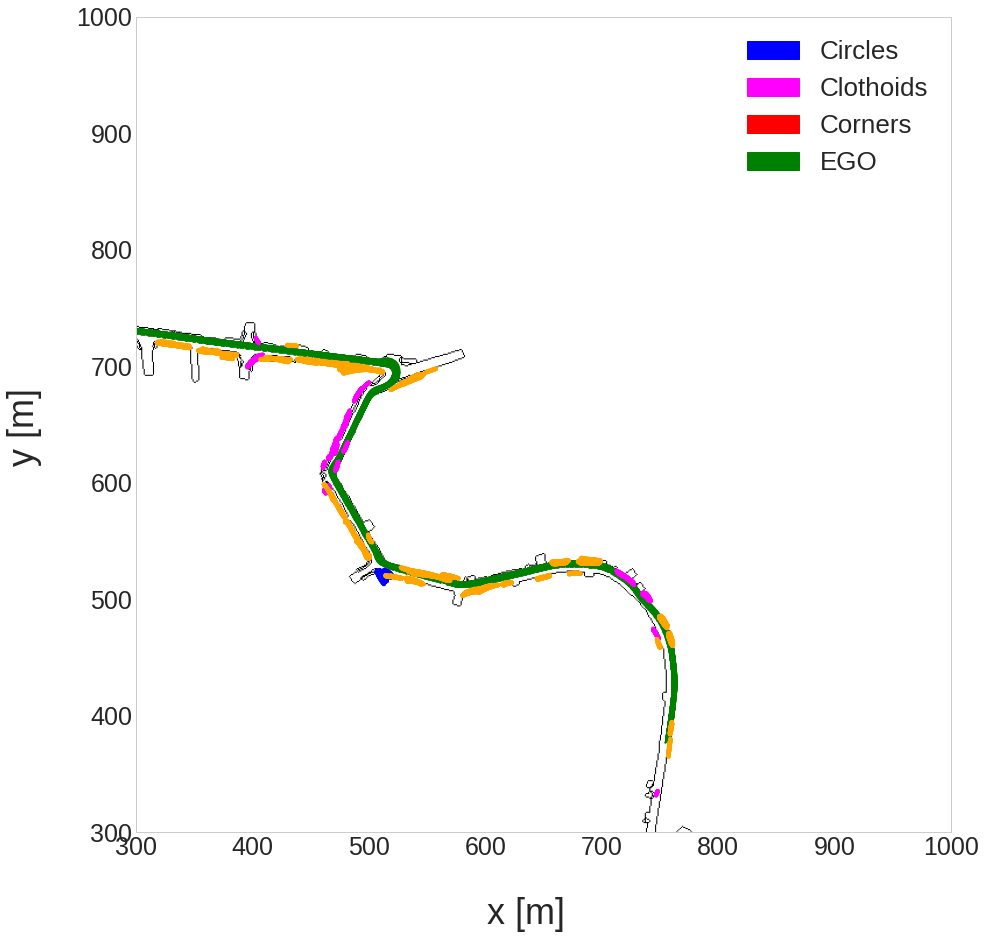

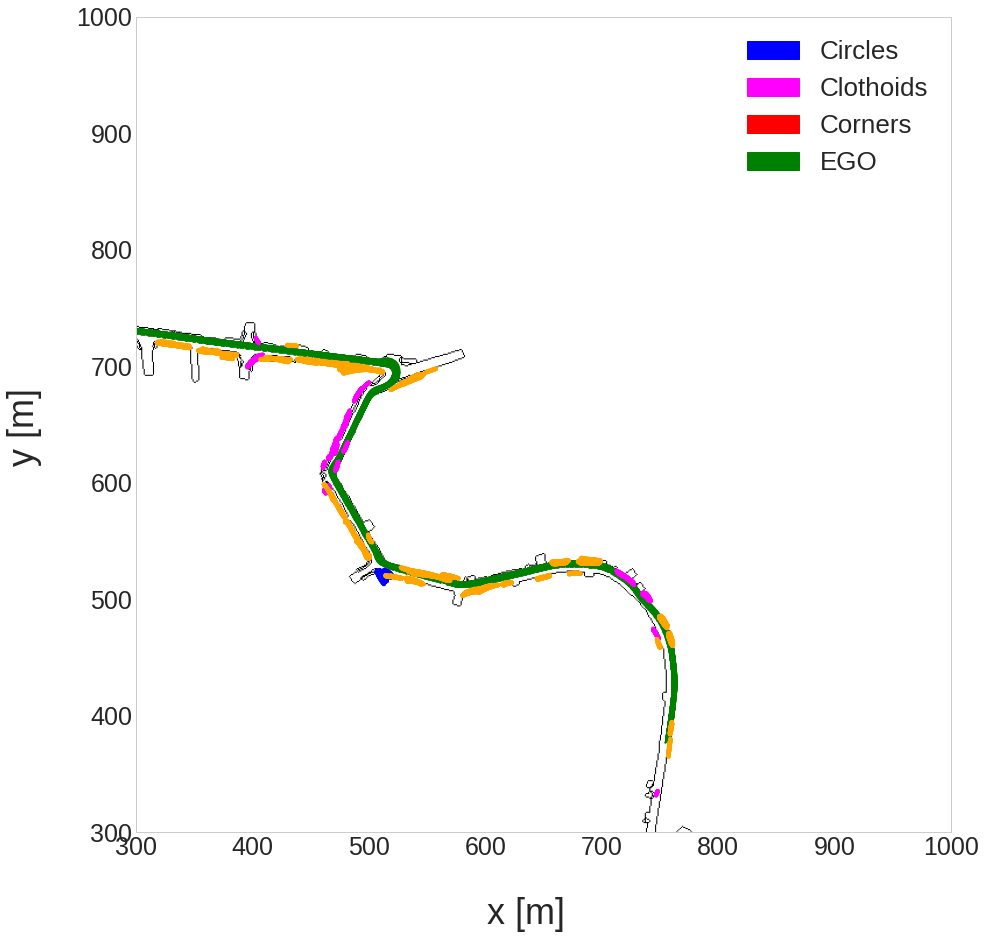

In [24]:
%load_ext autoreload
%autoreload 2
from database import NuscenesProcessedDatabase
from tqdm import tqdm
import matplotlib.pyplot as plt
#data = NuscenesProcessedDatabase(scene_id=scene)
from plotting import PolynomsOnMapGraph
import matplotlib.patches as mpatches
import numpy as np
import pickle
from plotting import PolynomsOnMapGraph
from shapes import *

def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"  
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
        
#path = "/media/kfir/wiseData/thesis/images_06_01_2024"
path = "/home/kfir/workspace/RadarLocalization/images"
nusc_map = sim.dataset.nusc_map

#scenes = [325, 365, 426, 494, 690, 814]
scenes = [325]
methods = ["_basic", "_improved"]

for scene in scenes:
    for method in methods: 
        fig, ax = plt.subplots(1,1,figsize=(20,15),sharex=True,sharey=True)
        exp_params = getExperimentParams(scene)
        data = NuscenesProcessedDatabase(scene_id=scene, base_path=path, dname=f"database{method}")
        plot = PolynomsOnMapGraph()

        for t in tqdm(range(0,exp_params["N"])):
            video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
            (lines, circles, clothoids, corners) = extractPriorShape(polynoms)

            colors = ['magenta'] * len(polynoms)
            labels = ['polynoms'] * len(polynoms)
            lines = np.array(lines).astype(int)
            circles = np.array(circles).astype(int)
            clothoids = np.array(clothoids).astype(int)
            corners = np.array(corners).astype(int)
            #print(f"t = {t} line = {lines} colors = {colors}")

            colors = ['orange' if i in lines else color for i, color in enumerate(colors)]
            labels = ['Lines' if i in lines else label for i, label in enumerate(labels)]
            colors = ['blue' if i in circles else color for i, color in enumerate(colors)]
            labels = ['Circles' if i in circles else label for i, label in enumerate(labels)]
            colors = ['magenta' if i in clothoids else color for i, color in enumerate(colors)]
            labels = ['Clothoids' if i in clothoids else label for i, label in enumerate(labels)]
            colors = ['red' if i in corners else color for i, color in enumerate(colors)]
            labels = ['Corners' if i in corners else label for i, label in enumerate(labels)]

            #polynoms = [polynom for index, polynom in enumerate(polynoms) if index not in lines]
            #colors = [color for index, color in enumerate(colors) if index not in lines]
            #labels = [label for index, label in enumerate(labels) if index not in lines]

            #print(colors, clothoids, corners, circles)

            ax = plot.run(t, np.array(video_data['pos']), video_data['heading'], video_data["ego_path"], polynoms, nusc_map, fig, ax, xlimits=[300, 1000], ylimits=[300, 1000], colors=colors,labels=labels, \
                          ego_size=4)

        ax.tick_params(axis="x", labelsize=25)
        ax.tick_params(axis="y", labelsize=25)
        ax.tick_params(axis="x", labelsize=25)
        ax.tick_params(axis="y", labelsize=25)
        fig.text(0.5, 0.04, 'x [m]', ha='center', fontsize=36)
        fig.text(0.14, 0.5, 'y [m]', va='center', rotation='vertical', fontsize=36)

        #line_patch = mpatches.Patch(color='magenta', label='Lines')
        circle_patch = mpatches.Patch(color='blue', label='Circles')
        clothoid_patch = mpatches.Patch(color='magenta', label='Clothoids')
        corner_patch = mpatches.Patch(color='red', label='Corners')
        ego_patch = mpatches.Patch(color='green', label='EGO')
        ax.legend(handles=[circle_patch, clothoid_patch, corner_patch, ego_patch], prop={'size': 26})
        fig.savefig(f'{path}/graphs/shapes_{scene}{method}.png')

# Video

In [ ]:
%load_ext autoreload
%autoreload 2
from database import NuscenesProcessedDatabase
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotting import PolynomsOnMapGraph
import matplotlib.patches as mpatches
import numpy as np
import pickle
from simulation import NuscenesSimulation
from plotting import *

class DummyModel():
    def __init__(self):
        self.mm = True
        
#try:
    #print("video_list", video_list)
#except:

method="_improved"
scene = 365
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)
data = NuscenesProcessedDatabase(scene_id=scene, dname=f"database{method}")


nusc_map = sim.dataset.nusc_map
video_with_priors = True


fig, ax = plt.subplots(1,1,figsize=(20,20))

frames = range(0,10)

ax.tick_params(axis="x", labelsize=25)
ax.tick_params(axis="y", labelsize=25)
ax.set_xlabel('x [m]', fontsize=30, labelpad=25)
ax.set_ylabel('y [m]', fontsize=30, labelpad=25)

dirname = f"images/video_{scene}{method}"
os.system("mkdir -p " + dirname)

#ax = generateLocalizationFullGraph(data, frames, fig, ax, nusc_map, dirname=dirname, xlimits=[], ylimits=[])

In [ ]:
%load_ext autoreload
%autoreload 2
from plotting import *

exp_params = getExperimentParams(scene)
frames = range(0,exp_params["N"])

generateDetectionsFullGraph(data, frames, nusc_map, dirname=dirname, xlimits=[], ylimits=[])

# Score Analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
self.dir_name /home/kfir/workspace/RadarLocalization/images/365/database_basic


INFO - 2024-01-08 00:05:54,695 - geos - Self-intersection at or near point 836.93610249425376 1482.0292367715256


IndexError: list index out of range

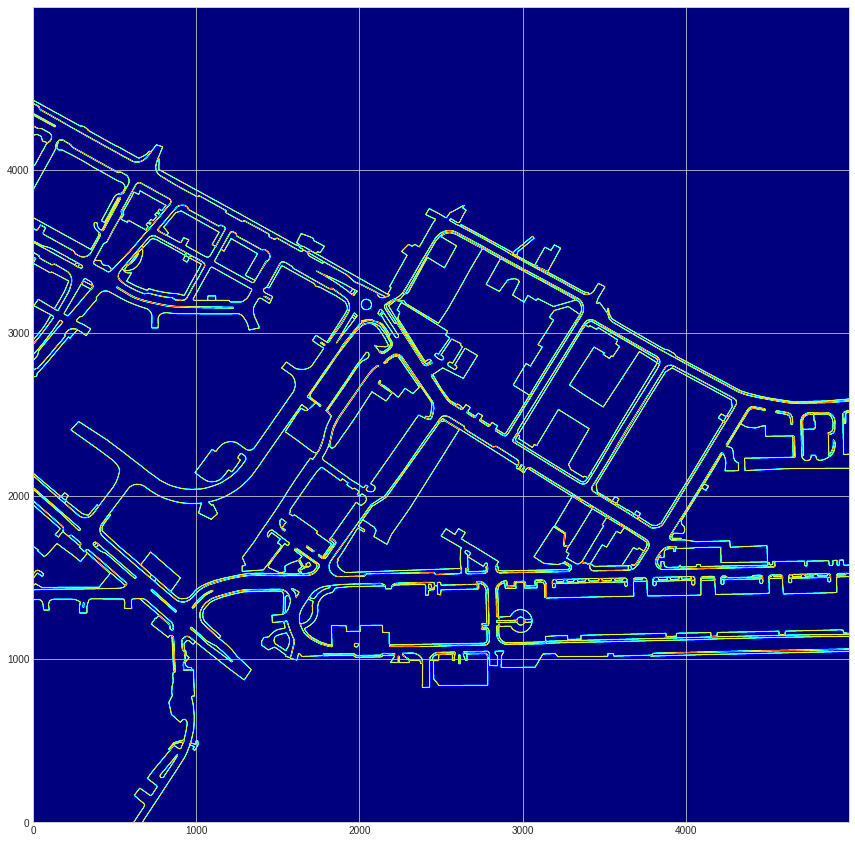

In [20]:
%load_ext autoreload
%autoreload 2
from database import NuscenesProcessedDatabase
from plotting import PolynomsOnMapGraph
from map_utils import build_probability_map, scatter_to_image, drawLanes, getCombinedMap
from map_utils import build_probability_map, scatter_to_image, drawLanes
from MapMatchingNDT import PF

class DummyModel():
    def __init__(self):
        self.mm = True

#sim = NuscenesSimulation(nusc=nusc, model=DummyModel(), scene_id=365, Nmax=1600, video_list=video_list, save_processed=False)
#path = "/media/kfir/wiseData/thesis/images_06_01_2024"
path = "/home/kfir/workspace/RadarLocalization/images"
data = NuscenesProcessedDatabase(scene_id=365, base_dir=path, dname="database_basic")
video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
first_pos = translation

t = 920
video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)

patch_size=1000
edges = getCombinedMap(nuscMap=sim.dataset.nusc_map, worldRef=translation, patchSize=patch_size, res_factor=5)
probability_map1 = build_probability_map(edges, sigma=12.)
probability_map2 = build_probability_map(edges, sigma=2.)
fig, ax = plt.subplots(1,1,figsize=(20,15),sharex=True,sharey=True)
sc = ax.imshow(probability_map2, origin='lower',cmap='jet')
#ax.set_xlim([3000,4000])
#ax.set_ylim([1000,2000])
#translation = [0,0]
res_factor=5.

plot = PolynomsOnMapGraph()
plot.counter = 1
plot.first_pos = first_pos
plot.patch_size = patch_size

#dataset.nusc_map

def calcScore(probMap, scatter, mapRes, mapCenter):
    im = scatter_to_image(scatter, res_factor=mapRes, center = mapCenter, patch_size=patch_size)
    score = im*probMap
    valid_ind = (score != 0)
    valid_len = np.count_nonzero(valid_ind)
    #print(f"score[valid_ind]={score[valid_ind]}")
    score[valid_ind] = (1./score[valid_ind]) / mapRes
    return score

def getElements(state):
    print(state)
    x_elements = np.linspace(state["x_start"], state["x_end"], int(np.ceil(np.abs(state["x_end"]-state["x_start"]))*10))
    y_elements = state["f"](x_elements)
    elements = np.array([x_elements, y_elements]).T if state["fxFlag"] else np.array([y_elements, x_elements]).T
        
    return elements

def getNearestNeighbor(transformed_polynom, edges, translation, mapCenter, probability_map1, probability_map2):
    high_sigma_score = calcScore(probability_map1, transformed_polynom, mapRes=5., mapCenter=translation)
    width = height = edges.shape[1]
    #print(edges.)
    world_xs,world_xe,world_ys,world_ye = transformed_polynom[0,0], transformed_polynom[-1,0], transformed_polynom[0,1], transformed_polynom[-1,1]
    #get relevant patch from map
    padding = 20
    #print(f"world_xs = {world_xs} world_ys = {world_ys}")
    #print(f"translation = {translation}")
    map_limits = PF.world2Map(np.array([[world_xs,world_ys],[world_xe,world_ye]]), translation, mapCenter, mapRes=5.)
    #print(f"map_limits = {map_limits}")
    map_xs,map_xe,map_ys,map_ye = max(0, int(min(map_limits[0,0], map_limits[1,0])) - padding), min(width-1, int(max(map_limits[0,0], map_limits[1,0])) + padding), max(0, int(min(map_limits[0,1], map_limits[1,1])) - padding), min(height-1, int(max(map_limits[0,1], map_limits[1,1])) + padding)
    #print(f"map_xs={map_xs},map_xe={map_xe},map_ys={map_ys},map_ye={map_ye}")
    (row,col) = np.where(edges[map_ys:map_ye,map_xs:map_xe])
    #print(f"row={row} col={col}")
    #if there are any boundary points in the map
    boundary_points = None
    if row.shape[0] > 0:
        boundary_points = PF.map2World(np.array([col+map_xs, row+map_ys]).astype('float64'), translation, mapCenter, mapRes=5.)
        boundary_points = boundary_points.T

        #Find nearest neighbor point on the map
        eucld_dist = np.linalg.norm(boundary_points-polynom_mid_point,axis=1)
        it = eucld_dist.argmin()
        #Calc translation
        txy = boundary_points[it,:] - polynom_mid_point
        #print(np.linalg.norm(txy))
        #print(f"txy = {txy} boundary_points={boundary_points}")
        if(np.linalg.norm(txy)) < 6:
            #Translate polynom
            polynom_translated = transformed_polynom + txy
            #print(f"polynom_mid_point = {polynom_mid_point}")
            #print(f"boundary_points = {boundary_points} polynom_translated = {polynom_translated}")
            #Compute low sigma score for translated polynom(shape)
            low_sigma_score = calcScore(probMap=probability_map2, scatter=polynom_translated, mapRes=5., mapCenter=translation)
        else:
            low_sigma_score = calcScore(probMap=probability_map2, scatter=transformed_polynom, mapRes=5., mapCenter=translation)
            
    print(f"high_sigma_score.shape = {high_sigma_score.shape} high_sigma_score = {high_sigma_score} low_sigma_score = {low_sigma_score}")
    total_score = np.sum(np.sum(0.5*high_sigma_score+0.5*low_sigma_score))
    print(f"total_score = {total_score} low_sigma_score={np.sum(np.sum(low_sigma_score))} high_sigma_score={np.sum(np.sum(high_sigma_score))}")
                
    
pol_id = 0
scatter = getElements(polynoms[pol_id])
ax = plot.run(t, np.array(video_data['pos']), video_data['heading'], video_data["ego_path"], [polynoms[pol_id]], sim.dataset.nusc_map, fig, ax, res_factor=5.)
print(f"mm_results['pf_mean_pos']={mm_results['pf_mean_pos']}")
print(f"mm_results['pf_mean_theta']={np.rad2deg(mm_results['pf_mean_theta'])} video_data['heading']={video_data['heading']}")
ax = drawEgo(x0=res_factor*(mm_results["pf_mean_pos"][0]-first_pos[0]+patch_size*0.5),y0=res_factor*(mm_results["pf_mean_pos"][1]-first_pos[1]+patch_size*0.5),angle=np.rad2deg(mm_results["pf_mean_theta"])+90,ax=ax,edgecolor='blue',facecolor='blue',width=10,height=20)
#score = calcScore(probability_map1, scatter, mapRes=5., mapCenter=translation)
#polynom_mid_point = scatter[int(scatter.shape[0]/2),:]
#print(f"score is = {np.sum(np.sum(score))} while scatter.shape = {scatter.shape} polynom_mid_point = {polynom_mid_point} start = {scatter[0,:]}")
mapCenter = np.array(edges.shape) / 2
getNearestNeighbor(scatter, edges, translation, mapCenter, probability_map1, probability_map2)


# Create Error(t) Graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
self.dir_name /home/kfir/workspace/RadarLocalization/images/325/database_improved
self.dir_name /home/kfir/workspace/RadarLocalization/images/325/database_basic
found problematic index! idx=916 pf_along_track_errors_arr[idx]=3.1377925517314225
found problematic index! idx=917 pf_along_track_errors_arr[idx]=3.09405759133017
found problematic index! idx=918 pf_along_track_errors_arr[idx]=3.0715479972288904
found problematic index! idx=919 pf_along_track_errors_arr[idx]=2.6974187898617856
found problematic index! idx=920 pf_along_track_errors_arr[idx]=2.6369479786678767
found problematic index! idx=921 pf_along_track_errors_arr[idx]=2.6476896741673954
found problematic index! idx=922 pf_along_track_errors_arr[idx]=2.64160293384748
found problematic index! idx=923 pf_along_track_errors_arr[idx]=2.6706659678303595
found problematic index! idx=924 pf_along_track_errors_arr[idx]=2.3341895852137213
found pr

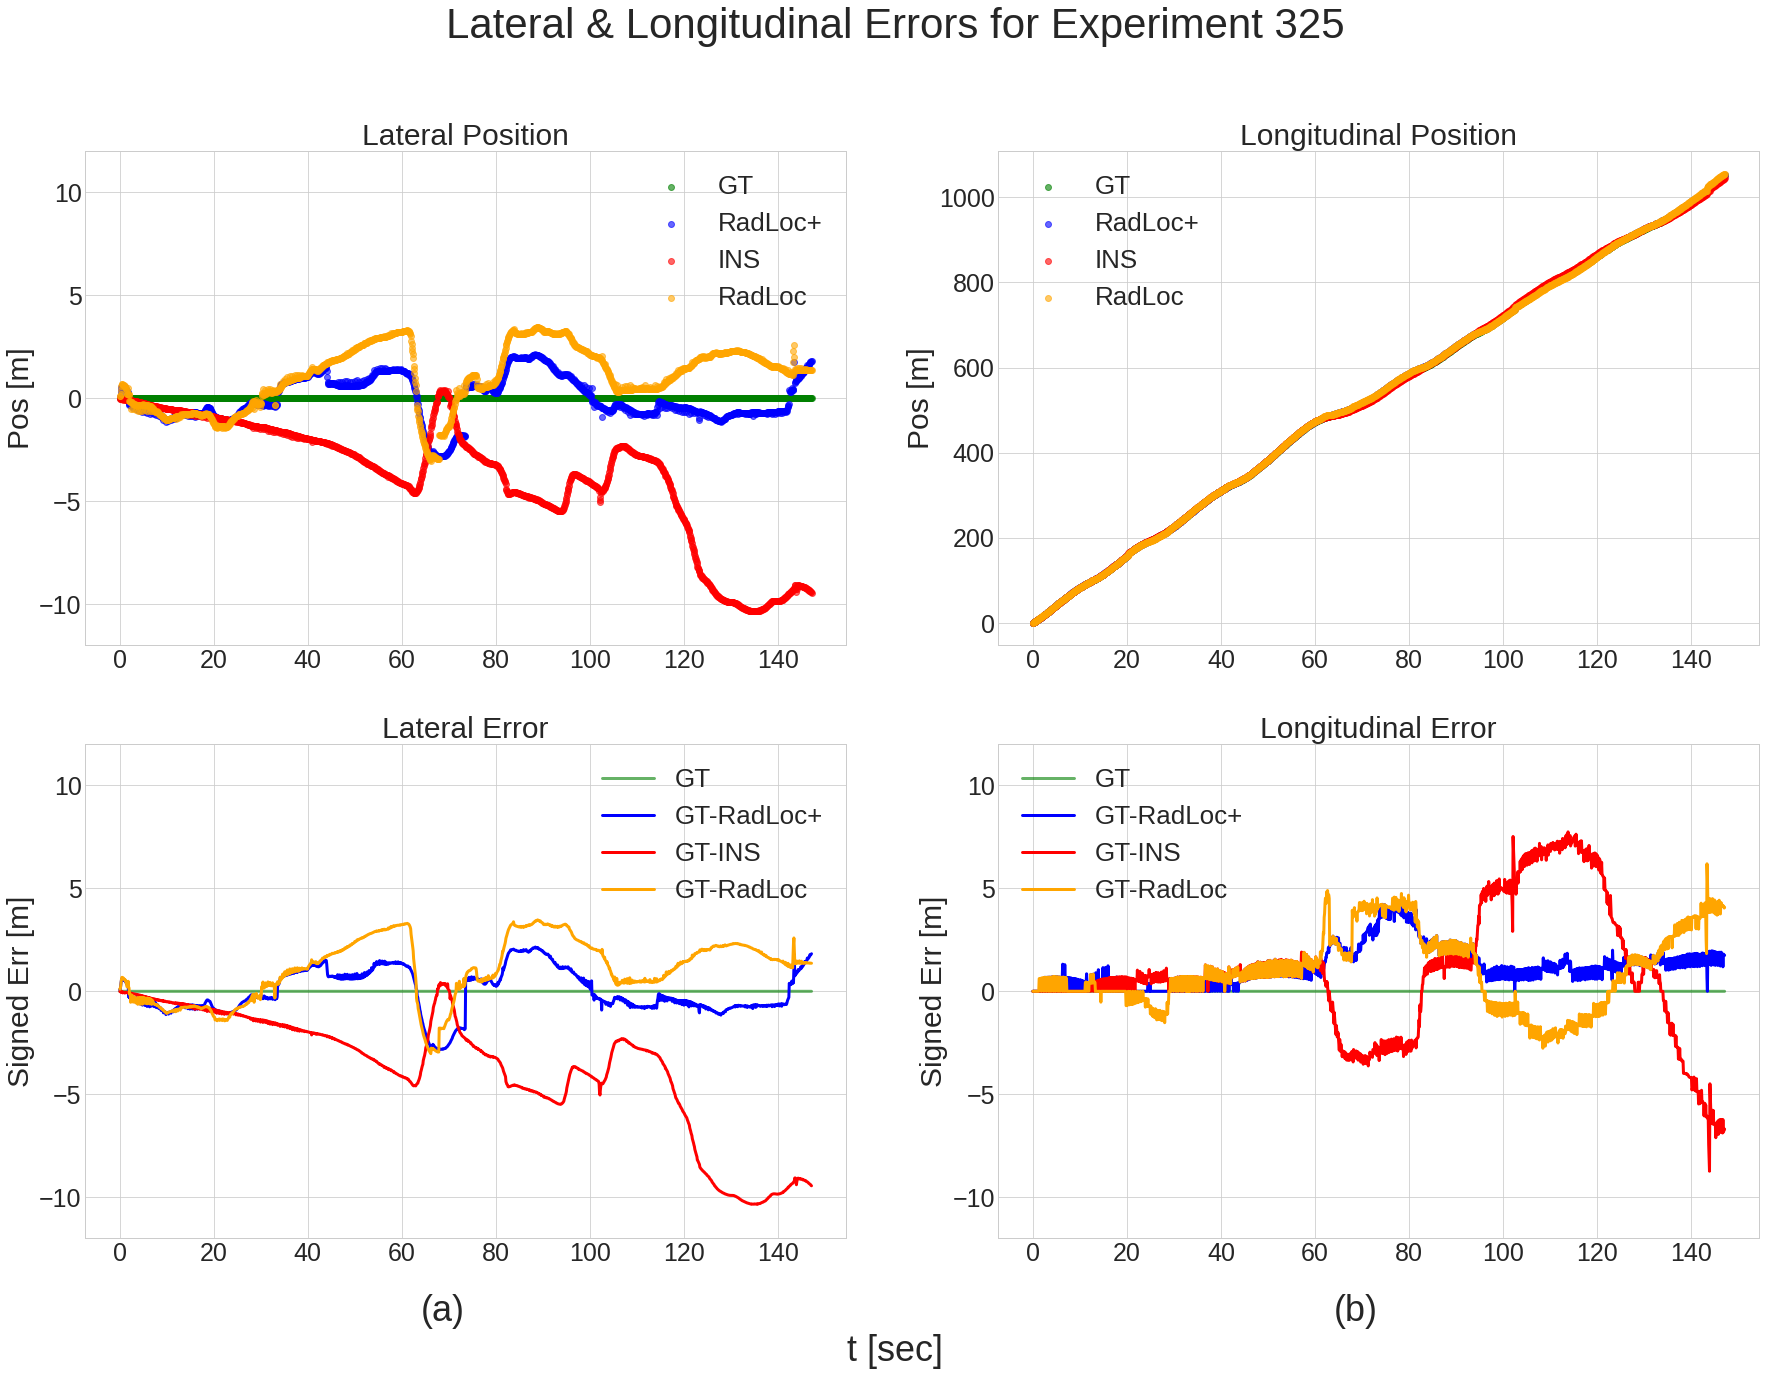

In [23]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation
from database import NuscenesProcessedDatabase
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotting import *

#path ="/media/kfir/wiseData/thesis/images_06_01_2024"
path ="/home/kfir/workspace/RadarLocalization/images"
#scenes = [325, 365, 426, 494, 690, 814]
scenes = [325]

for scene in scenes:
    data_improved = NuscenesProcessedDatabase(scene_id=scene, base_dir=path, dname="database_improved")
    data_basic = NuscenesProcessedDatabase(scene_id=scene, base_dir=path, dname='database_basic')
    exp_params = getExperimentParams(scene)

    fig, ax = plt.subplots(2,2,figsize=(30,20))
    frames = range(1,exp_params["N"])

    ax = generateGraphCrossAlong(data_improved, frames, ax, label='RadLoc+', color='blue', INS=True, GT=True)
    ax = generateGraphCrossAlong(data_basic, frames, ax, label='RadLoc', color='orange', INS=False, GT=False)

    ax[0,0].tick_params(axis="x", labelsize=25)
    ax[0,0].tick_params(axis="y", labelsize=25)
    ax[0,1].tick_params(axis="x", labelsize=25)
    ax[0,1].tick_params(axis="y", labelsize=25)
    ax[1,0].tick_params(axis="x", labelsize=25)
    ax[1,0].tick_params(axis="y", labelsize=25)
    ax[1,1].tick_params(axis="x", labelsize=25)
    ax[1,1].tick_params(axis="y", labelsize=25)
    fig.text(0.5, 0.04, 't [sec]', ha='center', fontsize=36)

    #fig.text(0.5, 0.04, 'x [m]', ha='center', fontsize=36)
    #fig.text(0.14, 0.5, 'y [m]', va='center', rotation='vertical', fontsize=36)
    ax[0,0].legend(loc='upper right',prop={'size': 26})
    ax[0,0].legend(prop={'size': 26})
    ax[0,0].set_title('Lateral Position', fontsize=30)
    ax[0,0].set_ylabel('Pos [m]', fontsize=30)
    #ax[0,0].set_ylim(-22,22)
    #ax[0,0].set_ylim(-8,8)
    ax[0,0].set_ylim(-12,12)
    ax[1,0].legend(loc='upper right',prop={'size': 26})
    ax[1,0].legend(prop={'size': 26})
    ax[1,0].set_title('Lateral Error', fontsize=30)
    ax[1,0].set_ylabel('Signed Err [m]', fontsize=30)
    #ax[1,0].set_ylim(-22,22)
    #ax[1,0].set_ylim(-8,8)
    ax[1,0].set_ylim(-12,12)
    ax[0,1].legend(loc='upper right',prop={'size': 26})
    ax[0,1].legend(prop={'size': 26})
    ax[0,1].set_title('Longitudinal Position', fontsize=30)
    ax[0,1].set_ylabel('Pos [m]', fontsize=30)
    ax[1,1].legend(loc='upper right',prop={'size': 26})
    ax[1,1].legend(prop={'size': 26})
    ax[1,1].set_title('Longitudinal Error', fontsize=30)
    ax[1,1].set_ylabel('Signed Err [m]', fontsize=30)
    #ax[1,1].set_ylim(-22,22)
    #ax[1,1].set_ylim(-8,8)
    ax[1,1].set_ylim(-12,12)
    #ax[0,1].set_xlabel('t [sec]', fontsize=28, labelpad=25)
    #ax[1].set_ylabel('y [m]', fontsize=28, labelpad=25)
    #ax[1,0].text(frames[-1]/24, -28, '(a)', ha='center', fontsize=36)
    #ax[1,1].text(frames[-1]/24, -28, '(b)', ha='center', fontsize=36)
    ax[1,0].text(frames[-1]/24, -16, '(a)', ha='center', fontsize=36)
    ax[1,1].text(frames[-1]/24, -16, '(b)', ha='center', fontsize=36)
    fig.suptitle(f'Lateral & Longitudinal Errors for Experiment {scene}', fontsize=42)
    fig.savefig(f'{path}/graphs/err_t_{scene}.png')

# Create RMSE & Max Results

In [25]:
%load_ext autoreload
%autoreload 2
from metrics import *

path ="/media/kfir/wiseData/thesis/images_05_01_2024"
#scenes = [325, 365, 426, 494, 690, 814]
scenes = [325, 365]
methods = ["_basic", "_improved"]

for scene in scenes:
    for method in methods:
        #sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=2000, video_list=video_list, save_processed=False)
        data = NuscenesProcessedDatabase(scene_id=scene, base_path=path, dname=f"database{method}")
        exp_params = getExperimentParams(scene)

        N = exp_params["N"]

        video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
        ego_path = video_data["ego_path"][:,0:2]#sim.dataset.getEgoPath()[:N,0:2]#video_data["ego_path"][0:1800,0:2]
        ego_trns = video_data["ego_trns"]#sim.dataset.ego_trns[:N]#video_data["ego_trns"][0:1800]
        pf_pos = np.zeros((N,2))
        imu_pos = np.zeros((N,2))

        for t in range(0,N):
            video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
            pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
            imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

        (pf_rmse_lat, pf_rmse_lon, imu_rmse_lat, imu_rmse_lon, pf_max_lat, pf_max_lon, imu_max_lat, imu_max_lon) = \
        calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)
        max_pf_lat = np.max(pf_pos[:,0])
        print(f"Scene {scene} method {method} pf_rmse_lat={pf_rmse_lat} pf_rmse_lon = {pf_rmse_lon} imu_rmse_lat = {imu_rmse_lat} imu_rmse_lon = {imu_rmse_lon}")
        print(f"Scene {scene} method {method} pf_max_lat={pf_max_lat} pf_max_lon = {pf_max_lon} imu_max_lat = {imu_max_lat} imu_max_lon = {imu_max_lon}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
self.dir_name images/325/database_basic


100%|██████████| 1650/1650 [00:00<00:00, 4820.36it/s]


Scene 325 method _basic pf_rmse_lat=1.8298997786287132 pf_rmse_lon = 2.0489485200878517 imu_rmse_lat = 4.863572237677936 imu_rmse_lon = 3.322731953709633
Scene 325 method _basic pf_max_lat=3.4664603352293306 pf_max_lon = 6.193125946227497 imu_max_lat = 10.343048653042084 imu_max_lon = 8.737059334548803
self.dir_name images/325/database_improved


100%|██████████| 1650/1650 [00:00<00:00, 4792.39it/s]


Scene 325 method _improved pf_rmse_lat=1.0808084625205472 pf_rmse_lon = 1.5498590721628838 imu_rmse_lat = 4.863572237677936 imu_rmse_lon = 3.322731953709633
Scene 325 method _improved pf_max_lat=2.8287130296728393 pf_max_lon = 4.225242245833556 imu_max_lat = 10.343048653042084 imu_max_lon = 8.737059334548803
self.dir_name images/365/database_basic


100%|██████████| 1120/1120 [00:00<00:00, 4887.35it/s]


Scene 365 method _basic pf_rmse_lat=1.2693186859909829 pf_rmse_lon = 0.8469600524934108 imu_rmse_lat = 2.808383434390442 imu_rmse_lon = 2.5170371876564577
Scene 365 method _basic pf_max_lat=3.1304000487193986 pf_max_lon = 2.0131987378478726 imu_max_lat = 4.800726366798732 imu_max_lon = 4.584477098824891
self.dir_name images/365/database_improved


100%|██████████| 1120/1120 [00:00<00:00, 4889.07it/s]

Scene 365 method _improved pf_rmse_lat=1.128055865204913 pf_rmse_lon = 0.6970592310869317 imu_rmse_lat = 2.808383434390442 imu_rmse_lon = 2.5170371876564577
Scene 365 method _improved pf_max_lat=2.201289912204007 pf_max_lon = 1.864157435835498 imu_max_lat = 4.800726366798732 imu_max_lon = 4.584477098824891


In [ ]:
from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *
import matplotlib.pyplot as plt

def calculate_summations(n_lines, K):
    n = len(n_lines)
    step = n // K

    result = [sum(n_lines[i * step:(i + 1) * step]) for i in range(K)]

    return result

scenes = [325, 365, 426, 494, 690, 814]

for scene in scenes:
    data = NuscenesProcessedDatabase(scene_id=scene, base_path=path, dname="database_basic")
    exp_params = getExperimentParams(scene)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
    N = exp_params["N"]
    ego_path = video_data["ego_path"][:N,0:2]
    ego_trns = video_data["ego_trns"][:N]

    n_lines = np.zeros(N)
    n_circles = np.zeros(N)
    n_clothoids = np.zeros(N)
    n_corners = np.zeros(N)

    for t in range(0,N):
        video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
        if t == 10:
            print(f"polynoms = {polynoms}")
        (lines, circles, clothoids, corners) = classifyShape(polynoms)
        #print(t, (lines, circles, clothoids, corners))
        n_lines[t] = len(lines)
        n_circles[t] = len(circles)
        n_clothoids[t] = len(clothoids)
        n_corners[t] = len(corners)

    t_lines = np.sum(n_lines > 0)
    t_circles = np.sum(n_circles > 0)
    t_clothoids = np.sum(n_clothoids > 0)
    t_corners = np.sum(n_corners > 0)

    print(f"========================\n ============ Scene = {scene} ============ \n ========================")
    print(f"#lines = {np.sum(n_lines)} #circles = {np.sum(n_circles)} #clothoids={np.sum(n_clothoids)} #corners={np.sum(n_corners)}")
    print(f"T lines = {t_lines / N * 100} [%] T circles = {t_circles / N* 100} [%] T clothoids={t_clothoids / N* 100} [%] T corners={t_corners / N* 100} [%]")

    K = 10
    fig, ax = plt.subplots(1,1,figsize=(20,15))

    t = np.linspace(0, N / 12.5, 11)[0:-1]
    ax.step(t, calculate_summations(n_lines, K), label='Lines')
    ax.step(t, calculate_summations(n_circles, K), label='Circles')
    ax.step(t, calculate_summations(n_clothoids, K), label='Clothoids')
    ax.step(t, calculate_summations(n_corners, K), label='Corners')
    ax.legend(prop={'size': 26})
    plt.xticks(fontsize=20) 
    plt.yticks(fontsize=20) 
    plt.xlabel('t [sec]', fontsize=32, labelpad=20.0)
    plt.ylabel('#', fontsize=32, labelpad=20.0)
    ax.set_title(label=f"Number of shapes detected along Scene {scene}", y=1.03, fontsize=36)
    fig.savefig(f'{path}/graphs/shape_dist_{scene}.png')